## Design Backward Induction for the Simplified Soccer Case

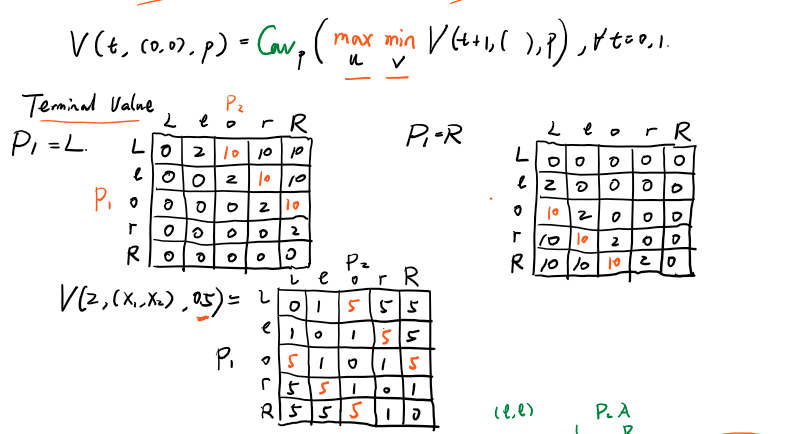

In [1]:
import numpy as np

In [2]:
import matplotlib.pyplot as plt

In [3]:
# Helper function to print the payoff table
def printMatrix(s):

    # Do heading
    print("     ", end="")
    for j in range(len(s[0])):
        print("%5s " % j, end="")
    print()
    print("     ", end="")
    for j in range(len(s[0])):
        print("------", end="")
    print()
    # Matrix contents
    for i in range(len(s)):
        print("%3s |" % (i), end="") # Row nums
        for j in range(len(s[0])):
            if type(s[i][j]) == np.float64:
                temp = round(s[i][j], 2)
            else:
                temp = s[i][j]
            print("%5s " % (temp), end="")
        print()

In [4]:
# states, types, and actions
states = ['L', 'l', 'O', 'r', 'R']
types = ['L', 'R']
actions = ['L', 'R']

In [5]:
# final value for type R
val_L_T = np.zeros((len(states), len(states)))
val_L_T[np.triu_indices(5, k=1)] = 2
val_L_T[np.triu_indices(5, k=2)] = 10

# final value for type L
val_R_T = val_L_T.T

In [6]:
# get some numbers for easier calculations
import itertools

a_pairs = itertools.product(states, repeat=2)
a_pairs = np.array(list(a_pairs))    

In [7]:
a_pairs = np.array([[''.join(a_pairs[i, :]) for i in range(len(a_pairs))]]) # make array of action pairs

In [8]:
a_pairs = a_pairs.reshape(5, 5)

## Define a function to get value at some time t and probability p

In [9]:
def get_av_val(val_a, val_b, p):
    return p*val_b + (1-p)*val_a

In [10]:
def get_prev_val(game_dict, s): # game dict maps states --> payoff | s - states in grid
    temp = np.full(s.shape, np.nan)
    action = np.full(s.shape, '%', dtype=str)
    a_map = {'0': 'L', '1': 'R'}
    for i in range(1, 4):
        payoff = np.zeros((2, 2)) # payoff matrix for the game
        payoff[0, 0] = game_dict[s[0, i-1]] # left left 
        payoff[1, 0] = game_dict[s[4, i-1]] # right left
        payoff[0, 1] = game_dict[s[0, i+1]] # left right
        payoff[1, 1] = game_dict[s[4, i+1]] # right right
        
        # now find maximin
        temp[1, i] = np.max(np.min(payoff, 1))
        action_idx = np.where(np.min(payoff, 1) == np.max(np.min(payoff, 1)))[0] # to check if there are same values
        action[1, i] = a_map[str(action_idx[0])] if len(action_idx) == 1 else 'A'
    
    temp[2:4, 1:4] = temp[1, 1:4] # symmetric 
    action[2:4, 1:4] = action[1, 1:4]
    
    
    return temp, action

In [11]:
def get_ini_val(game_dict, s):
    temp = np.full(s.shape, np.nan)
    action = np.full(s.shape, '%', dtype=str)
    a_map = {'0': 'L', '1': 'R'}
    # for the initial time only one state (0, 0) is possible
    i = 2
    payoff = np.zeros((2, 2))
    payoff[0, 0] = game_dict[s[i-1, i-1]] # left left 
    payoff[1, 0] = game_dict[s[i+1, i-1]] # right left
    payoff[0, 1] = game_dict[s[i-1, i+1]] # left right
    payoff[1, 1] = game_dict[s[i+1, i+1]] # right right
    
    # now find maximin
    temp[2, 2] = np.max(np.min(payoff, 1))
    action_idx = np.where(np.min(payoff, 1) == np.max(np.min(payoff, 1)))[0]
    action[2, 2] = a_map[str(action_idx[0])] if len(action_idx) == 1 else 'A'
    
    
    return temp, action

In [113]:
# try manually for T-1 stage
av_game = get_av_val(val_R_T, val_L_T, 0)  # value of average game at time T
av_game_dict = dict(zip(list(a_pairs.flatten()), list(av_game.flatten())))

In [114]:
printMatrix(av_game)

         0     1     2     3     4 
     ------------------------------
  0 |  0.0   0.0   0.0   0.0   0.0 
  1 |  2.0   0.0   0.0   0.0   0.0 
  2 | 10.0   2.0   0.0   0.0   0.0 
  3 | 10.0  10.0   2.0   0.0   0.0 
  4 | 10.0  10.0  10.0   2.0   0.0 


In [110]:
val_1, strategy = get_prev_val(av_game_dict, a_pairs)

In [111]:
printMatrix(val_1)

         0     1     2     3     4 
     ------------------------------
  0 |  nan   nan   nan   nan   nan 
  1 |  nan  10.0   2.0   0.0   nan 
  2 |  nan  10.0   2.0   0.0   nan 
  3 |  nan  10.0   2.0   0.0   nan 
  4 |  nan   nan   nan   nan   nan 


In [112]:
printMatrix(strategy)

         0     1     2     3     4 
     ------------------------------
  0 |    %     %     %     %     % 
  1 |    %     R     R     A     % 
  2 |    %     R     R     A     % 
  3 |    %     R     R     A     % 
  4 |    %     %     %     %     % 


In [17]:
inter_game_dict = dict(zip(list(a_pairs.flatten()), list(val_1.flatten())))
ini_val, ini_sigma = get_ini_val(inter_game_dict, a_pairs)

In [18]:
printMatrix(ini_val)

         0     1     2     3     4 
     ------------------------------
  0 |  nan   nan   nan   nan   nan 
  1 |  nan   nan   nan   nan   nan 
  2 |  nan   nan   5.0   nan   nan 
  3 |  nan   nan   nan   nan   nan 
  4 |  nan   nan   nan   nan   nan 


In [19]:
printMatrix(ini_sigma)

         0     1     2     3     4 
     ------------------------------
  0 |    %     %     %     %     % 
  1 |    %     %     %     %     % 
  2 |    %     %     A     %     % 
  3 |    %     %     %     %     % 
  4 |    %     %     %     %     % 


In [20]:
ps = np.linspace(0, 1, 100)
l = [] # state l for p2 
O = [] # state O for p2
r = [] # state r for P2
for p in ps:
    av_game = get_av_val(val_R_T, val_L_T, p)
    av_dict = dict(zip(list(a_pairs.flatten()), list(av_game.flatten())))
    val_0, _ = get_prev_val(av_dict, a_pairs)
    l.append(val_0[1, 1])
    O.append(val_0[1, 2])
    r.append(val_0[1, 3])

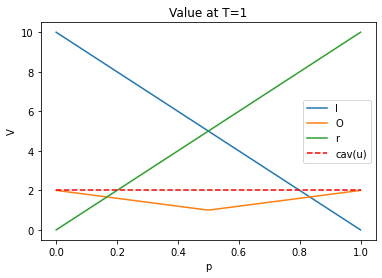

In [21]:
plt.plot(ps, l, label="l")
plt.plot(ps, O, label="O")
plt.plot(ps, r, label="r")
plt.xlabel('p')
plt.ylabel('V')
plt.title("Value at T=1")
plt.hlines(y=O[0], xmin=ps[0], xmax=ps[-1], color='red', linestyles='dashed', label="cav(u)")
plt.legend()

## Get value at initial time step for all Ps (a.k.a. Value of the Game)

In [22]:
ps = np.linspace(0, 1, 1000)
vals = []
# actions = []
for p in ps:
    av_game = get_av_val(val_R_T, val_L_T, p)  # value of average game at time T
    av_game_dict = dict(zip(list(a_pairs.flatten()), list(av_game.flatten())))
    val_1, _ = get_prev_val(av_game_dict, a_pairs)
    inter_game = dict(zip(list(a_pairs.flatten()), list(val_1.flatten())))
    val_0, s = get_ini_val(inter_game, a_pairs)
    vals.append(val_0[2, 2]) # initial stage has value at (0, 0) only 
#     actions.append(s[2, 2])

Text(0, 0.5, 'u (p)')

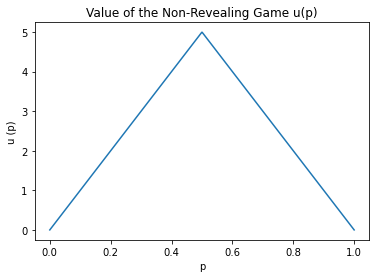

In [23]:
plt.plot(ps, vals)
plt.title('Value of the Non-Revealing Game u(p)')
plt.xlabel('p')
plt.ylabel('u (p)')

## Now lets look at P2's Value

In [24]:
def get_prev_val_2(game_dict, s):  # game dict maps states --> payoff | s - states in grid
    temp = np.full(s.shape, np.nan)
    action = np.full(s.shape, '%', dtype=str)
    a_map = {'0': 'L', '1': 'R'}
    for i in range(1, 4):
        payoff = np.zeros((2, 2))  # payoff matrix for the game
        payoff[0, 0] = game_dict[s[0, i - 1]]  # left left
        payoff[1, 0] = game_dict[s[4, i - 1]]  # right left
        payoff[0, 1] = game_dict[s[0, i + 1]]  # left right
        payoff[1, 1] = game_dict[s[4, i + 1]]  # right right

        # now find maximin
        temp[1, i] = np.max(np.min(payoff, 0))
        action_idx = np.where(np.min(payoff, 0) == np.max(np.min(payoff, 0)))[0]
        action[1, i] = a_map[str(action_idx[0])] if len(action_idx) == 1 else 'A'


    temp[2:4, 1:4] = temp[1, 1:4]  # symmetric
    action[2:4, 1:4] = action[1, 1:4]

    return temp, action

In [25]:
# the dual

# for 0<=x<=0.5 u(p) = 10x 
# for 0.5>=x>=1 u(p) = 10 (1-x)
def get_up(p):
    if p <= 0.5:
        return 10*p 
    else:
        return 10*(1-p)

# def factor(p):
#     return (1-p)/p

In [49]:
def plot_phat(p): # p is the game defined by nature's probability
    ps_hat = np.arange(-10, 10.25, 0.25)
#     ps_hat = np.array([10])
    actions = ['L', 'R']
    
    val_2_p_t1 = np.zeros((ps_hat.shape[0], a_pairs.shape[0], a_pairs.shape[1]))
#     actions = np.zeros((ps_hat.shape[0], a_pairs.shape[0], a_pairs.shape[1]))
    
    eps = 1e-9

    for i in range(len(ps_hat)):
        u = get_up(p)
        p2_hat = (u-p*ps_hat[i])/(1-p + eps*(p==1))  # prevent divide by 0
        min_game = np.minimum(ps_hat[i] - val_L_T, p2_hat - val_R_T)
        min_game_dict = dict(zip(list(a_pairs.flatten()), list(min_game.flatten())))
        val_2_p_t1[i], _ = get_prev_val_2(min_game_dict, a_pairs)

    val_2_p_t0 = np.zeros((ps_hat.shape[0], 2, 2))

    for i in range(val_2_p_t0.shape[1]):
        for j in range(val_2_p_t0.shape[2]):
            val_2_p_t0[:, i, j] = val_2_p_t1[:, 2*i+1, 2*j+1]

    payoff_t0 = np.zeros(ps_hat.shape[0])
    strategy_t0 = list()

    for i in range(val_2_p_t0.shape[0]):
        payoff_t0[i] = np.max(np.min(val_2_p_t0[i, :, :], 0))
        strategy_t0.append(actions[np.argmax(np.min(val_2_p_t0[i, :, :], 0))])
    
    plt.plot(ps_hat, payoff_t0, label="u")
    # plt.hlines(y=0, xmin=ps_hat[0], xmax=ps_hat[-1], color='red', linestyles='dashed', label="cav(u)")
    plt.vlines(x=10, ymin=np.min(payoff_t0), ymax=np.max(payoff_t0), linestyles='dashed', color='gray')
    plt.vlines(x=-10, ymin=np.min(payoff_t0), ymax=np.max(payoff_t0), linestyles='dashed', color='gray')
    plt.vlines(x=0, ymin=np.min(payoff_t0), ymax=np.max(payoff_t0), linestyles='dashed', color='gray')
    plt.legend(loc='best')
    plt.xlabel('$\hat{p}$')
    plt.ylabel('V')
    plt.title(f"Value at T0 for game with p = {p}")
    
    s_idx = np.where(payoff_t0 == np.max(payoff_t0))
    s_idx = [i for i in s_idx[0]]
    s_keys = [strategy_t0[i] for i in s_idx]
    s = {key: None for key in s_keys}
    if len(s) > 1: 
        s = {'A': None}
    print(f"Strategy at t=0 for P2 is: {list(s.keys())[0]}")
    return payoff_t0, strategy_t0

Strategy at t=0 for P2 is: R


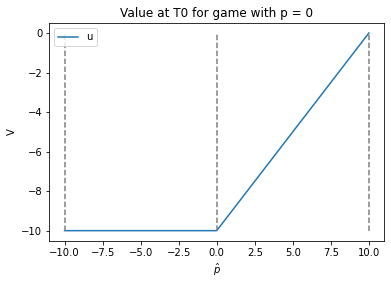

In [50]:
p0, s0 = plot_phat(0)

Strategy at t=0 for P2 is: R


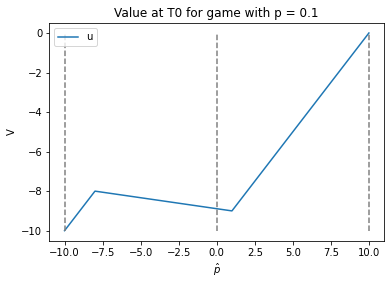

In [51]:
p01, s01 = plot_phat(0.1)

Strategy at t=0 for P2 is: R


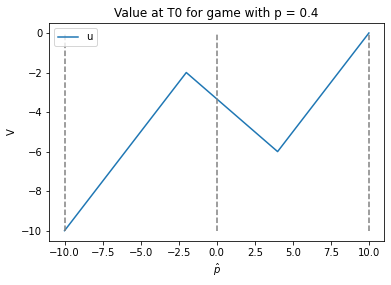

In [52]:
p04, s04 = plot_phat(0.4)

Strategy at t=0 for P2 is: A


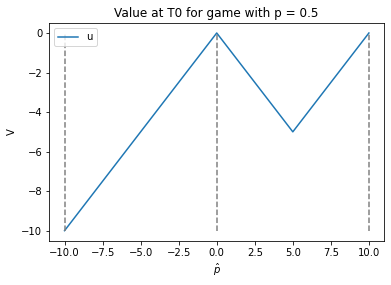

In [54]:
p05, s05 = plot_phat(0.5)

Strategy at t=0 for P2 is: L


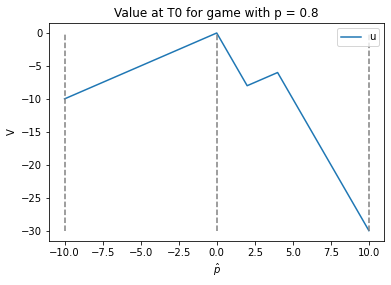

In [55]:
p08, s08 = plot_phat(0.8)

Strategy at t=0 for P2 is: L


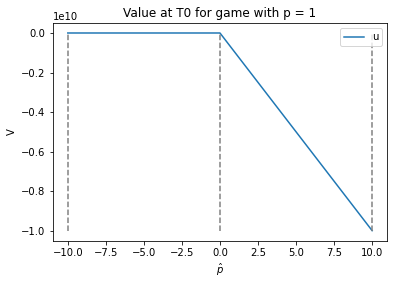

In [56]:
p1, s1 = plot_phat(1)

In [57]:
p = 0.1
p_hat = 10
u = get_up(p)
eps = 1e-9
p2_hat = (u-p*p_hat)/(1-p + eps*(p==1))  # prevent divide by 0
min_game = np.minimum(p_hat - val_L_T, p2_hat - val_R_T)
min_game_dict = dict(zip(list(a_pairs.flatten()), list(min_game.flatten())))

val_2 = get_prev_val_2(min_game_dict, a_pairs)

printMatrix(min_game)
print('\n')
printMatrix(val_2)

         0     1     2     3     4 
     ------------------------------
  0 |  0.0   0.0   0.0   0.0   0.0 
  1 | -2.0   0.0   0.0   0.0   0.0 
  2 |-10.0  -2.0   0.0   0.0   0.0 
  3 |-10.0 -10.0  -2.0   0.0   0.0 
  4 |-10.0 -10.0 -10.0  -2.0   0.0 


         0     1     2     3     4 
     ------------------------------
  0 |[nan nan nan nan nan] [ nan -10.  -2.   0.  nan] [ nan -10.  -2.   0.  nan] [ nan -10.  -2.   0.  nan] [nan nan nan nan nan] 
  1 |['%' '%' '%' '%' '%'] ['%' 'A' 'R' 'R' '%'] ['%' 'A' 'R' 'R' '%'] ['%' 'A' 'R' 'R' '%'] ['%' '%' '%' '%' '%'] 


## P2's Intermediate Value

In [58]:
def get_inter_val(p): # p is the game defined by nature's probability
    ps_hat = np.arange(-10, 10.25, 0.25)
    
    val_2_p_t1 = np.zeros((ps_hat.shape[0], a_pairs.shape[0], a_pairs.shape[1]))
    actions = np.full((ps_hat.shape[0], a_pairs.shape[0], a_pairs.shape[1]), '%', dtype='str')
    
    eps = 1e-9

    for i in range(len(ps_hat)):
        u = get_up(p)
        p2_hat = (u-p*ps_hat[i])/(1-p + eps*(p==1))  # prevent divide by 0
        min_game = np.minimum(ps_hat[i] - val_L_T, p2_hat - val_R_T)
        min_game_dict = dict(zip(list(a_pairs.flatten()), list(min_game.flatten())))
        val_2_p_t1[i], actions[i] = get_prev_val_2(min_game_dict, a_pairs)

    return val_2_p_t1, actions

In [100]:
nature = 0
value_t1, strategy = get_inter_val(nature)

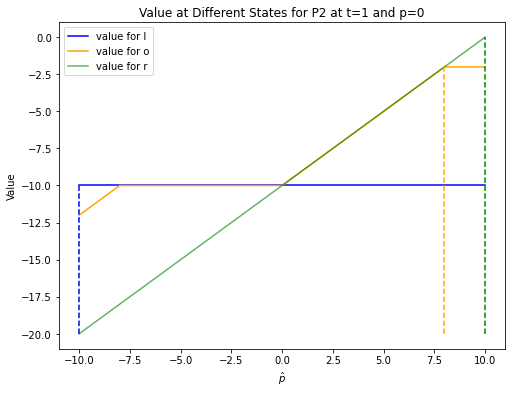

In [101]:
plt.rcParams["figure.figsize"] = (8, 6)
phat_range = np.arange(-10, 10.25, 0.25)
state_l = value_t1[:, 1, 1]
state_o = value_t1[:, 2, 2]
state_r = value_t1[:, 3, 3]
plt.plot(phat_range, state_l, label='value for l', color='blue')
plt.plot(phat_range, state_o, label='value for o', color='orange')
plt.plot(phat_range, state_r, alpha=0.6, label='value for r', color='green')
plt.vlines(x=phat_range[np.argmax(state_l)], ymin=np.min([state_l, state_o, state_r]), ymax=np.max(state_l), linestyles='dashed', color='blue')
plt.vlines(x=phat_range[np.argmax(state_o)], ymin=np.min([state_l, state_o, state_r]), ymax=np.max(state_o), linestyles='dashed', color='orange')
plt.vlines(x=phat_range[np.argmax(state_r)], ymin=np.min([state_l, state_o, state_r]), ymax=np.max(state_r), linestyles='dashed', color='green')
plt.legend()
plt.title(f'Value at Different States for P2 at t=1 and p={nature}')
plt.ylabel('Value')
plt.xlabel('$\hat{p}$')
plt.show()

In [102]:
st_l = strategy[:, 1, 1]
st_o = strategy[:, 2, 2]
st_r = strategy[:, 3, 3]
a_list_l = st_l[np.where(state_l == np.max(state_l))]
a_list_o = st_o[np.where(state_o == np.max(state_o))]
a_list_r = st_l[np.where(state_r == np.max(state_r))]

a_l = 'A' if ('L' in a_list_l and 'R' in a_list_l) else a_list_l[0]
a_o = 'A' if ('L' in a_list_o and 'R' in a_list_o) else a_list_o[0]
a_r = 'A' if ('L' in a_list_r and 'R' in a_list_r) else a_list_r[0]

In [103]:
f"action for state l is: {a_l}, o is: {a_o}, r is: {a_r}"

'action for state l is: L, o is: R, r is: A'

In [104]:
printMatrix(value_t1[np.argmax(state_r)])

         0     1     2     3     4 
     ------------------------------
  0 |  nan   nan   nan   nan   nan 
  1 |  nan -10.0  -2.0   0.0   nan 
  2 |  nan -10.0  -2.0   0.0   nan 
  3 |  nan -10.0  -2.0   0.0   nan 
  4 |  nan   nan   nan   nan   nan 


In [105]:
printMatrix(strategy[np.argmax(state_r)])

         0     1     2     3     4 
     ------------------------------
  0 |    %     %     %     %     % 
  1 |    %     A     R     R     % 
  2 |    %     A     R     R     % 
  3 |    %     A     R     R     % 
  4 |    %     %     %     %     % 


In [106]:
printMatrix(strategy[np.argmax(state_o)])

         0     1     2     3     4 
     ------------------------------
  0 |    %     %     %     %     % 
  1 |    %     A     R     R     % 
  2 |    %     A     R     R     % 
  3 |    %     A     R     R     % 
  4 |    %     %     %     %     % 


In [107]:
printMatrix(strategy[np.argmax(state_l)])

         0     1     2     3     4 
     ------------------------------
  0 |    %     %     %     %     % 
  1 |    %     L     L     A     % 
  2 |    %     L     L     A     % 
  3 |    %     L     L     A     % 
  4 |    %     %     %     %     % 


### Compare values at different time-steps

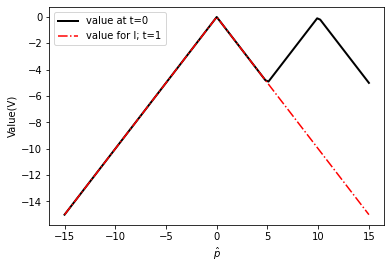

In [71]:
plt.plot(phat_range, p05, label='value at t=0', color='black', lw=2)
plt.plot(phat_range, state_l, label='value for l; t=1', color='red', linestyle='-.')
plt.legend()
plt.xlabel('$\hat{p}$')
plt.ylabel('Value(V)')
plt.show()

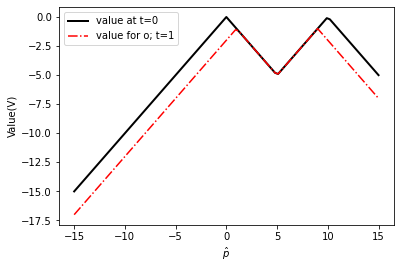

In [72]:
plt.plot(phat_range, p05, label='value at t=0', color='black', lw=2)
plt.plot(phat_range, state_o, label='value for o; t=1', color='red', linestyle='-.')
plt.legend()
plt.xlabel('$\hat{p}$')
plt.ylabel('Value(V)')
plt.show()

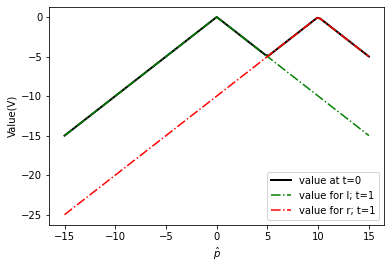

In [78]:
plt.plot(phat_range, p05, label='value at t=0', color='black', lw=2)
plt.plot(phat_range, state_l, label='value for l; t=1', color='green', linestyle='-.')
plt.plot(phat_range, state_r, label='value for r; t=1', color='red', linestyle='-.')
plt.legend()
plt.xlabel('$\hat{p}$')
plt.ylabel('Value(V)')
plt.show()

## Now let's consider a "larger" game

In [ ]:
num_states = 15
s = np.linspace(1, num_states, num_states)
states = list(itertools.product(s, repeat=2)) # center is (8, 8) ---> (7, 7) indices

In [ ]:
# payoff for P1: Type Left
val_L_T = np.zeros((len(s), len(s)))
for i in range(num_states):
    val_L_T[np.triu_indices(num_states, k = i)] = i

In [ ]:
val_L_T = val_L_T.reshape(15, 15)
val_R_T = val_L_T.T

In [ ]:
printMatrix(val_L_T)

In [ ]:
printMatrix(val_R_T)

In [ ]:
average = get_av_val(val_L_T, val_R_T, p=0.5)

In [ ]:
printMatrix(average)